In [1]:
%load_ext autoreload
%autoreload 2

# Original Benchmark

In [2]:
from spacecharge.original_freespace import igfun_efield

from spacecharge.testing import test_particles

In [3]:
import numpy as np


from scipy.signal import fftconvolve, oaconvolve
from scipy.interpolate import interpn

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,6)
%config InlineBackend.figure_format = 'retina'

In [4]:
# For saving reults for plotting
SAVE_EZ = {}
SAVE_Z = {}

In [5]:
RATIO = .01

NP = 10000000
SIGX = 0.001
SIGY = 0.001
SIGZ = 0.001 * RATIO
CHARGE = 1e-9

BINS = (128,128, 128)

particles, weights = test_particles(n_particle=NP, sigma_x=SIGX, sigma_y=SIGY, sigma_z=SIGZ,
                                total_charge=CHARGE)

# Boundaries
bmax = np.array([SIGX, SIGY, SIGZ])*6
bmin = -bmax
bmin, bmax

(array([-6.e-03, -6.e-03, -6.e-05]), array([6.e-03, 6.e-03, 6.e-05]))

In [6]:
# Bin
H, edges = np.histogramdd(particles, bins=BINS, range = np.array([bmin, bmax]).T, weights=weights )
# Get deltas
D = np.array([np.mean(np.diff(e)) for e in edges])

extents = np.array([(e.min(), e.max()) for e in edges])


# Make coordinate vectors for meshgrid
coordvecs = [np.linspace(e.min(), e.max(), BINS[i]) for i, e in enumerate(edges)]
coordvecs2 = [np.linspace(e.min()*2, e.max()*2, 2*BINS[i]) for i, e in enumerate(edges)]

extents = np.array([(e.min(), e.max()) for e in edges])
extents2 = np.array([(e.min()*2, e.max()*2) for e in edges]) # double

extents, extents2, D, np.sum(H)

(array([[-6.e-03,  6.e-03],
        [-6.e-03,  6.e-03],
        [-6.e-05,  6.e-05]]),
 array([[-0.012  ,  0.012  ],
        [-0.012  ,  0.012  ],
        [-0.00012,  0.00012]]),
 array([9.375e-05, 9.375e-05, 9.375e-07]),
 1.0000000000000013e-09)

In [7]:
# Make mesh points to calculate the Green functions on

X, Y, Z = np.meshgrid(*coordvecs, indexing='ij')  # Must have this indexing!!!
X2, Y2, Z2 = np.meshgrid(*coordvecs2, indexing='ij')
X.shape, Y2.shape

((128, 128, 128), (256, 256, 256))

In [8]:
%%time
G2 = igfun_efield(X2, Y2, Z2, 1, D[0], D[1], D[2], component='z')
G2.shape

CPU times: user 10.7 s, sys: 1.67 s, total: 12.4 s
Wall time: 12.4 s


(256, 256, 256)

In [9]:
%%time
# Convolve
R = fftconvolve(H, G2, mode='same')

CPU times: user 3.1 s, sys: 1.28 s, total: 4.38 s
Wall time: 4.45 s


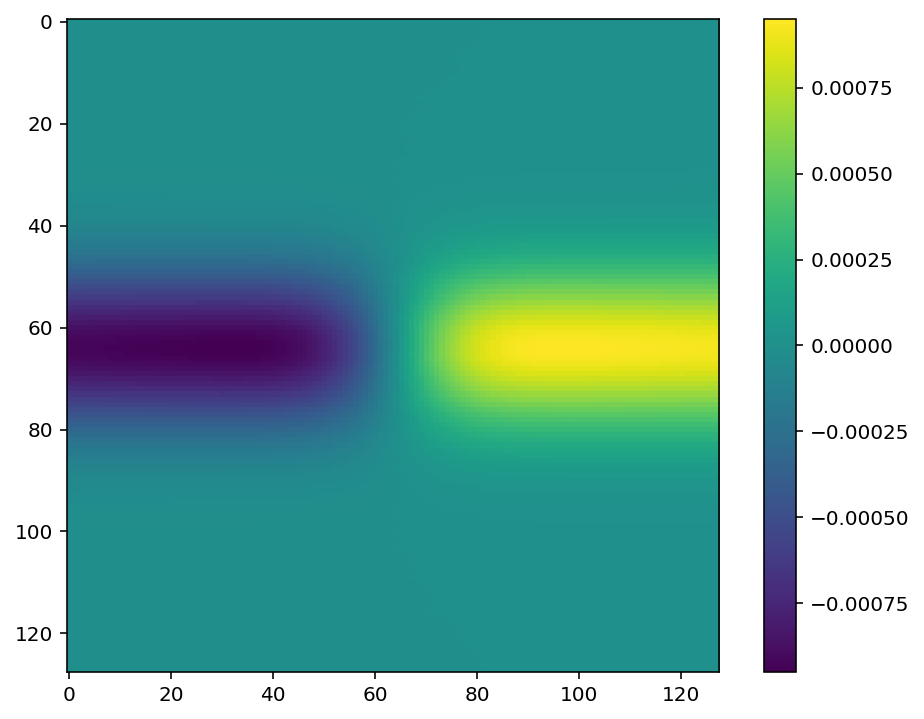

In [10]:
plt.imshow(R[:,BINS[1]//2,:])
plt.colorbar()

In [11]:
G2x = igfun_efield(X2, Y2, Z2, 1, D[0], D[1], D[2], component='x')
Rx = fftconvolve(H, G2x, mode='same')

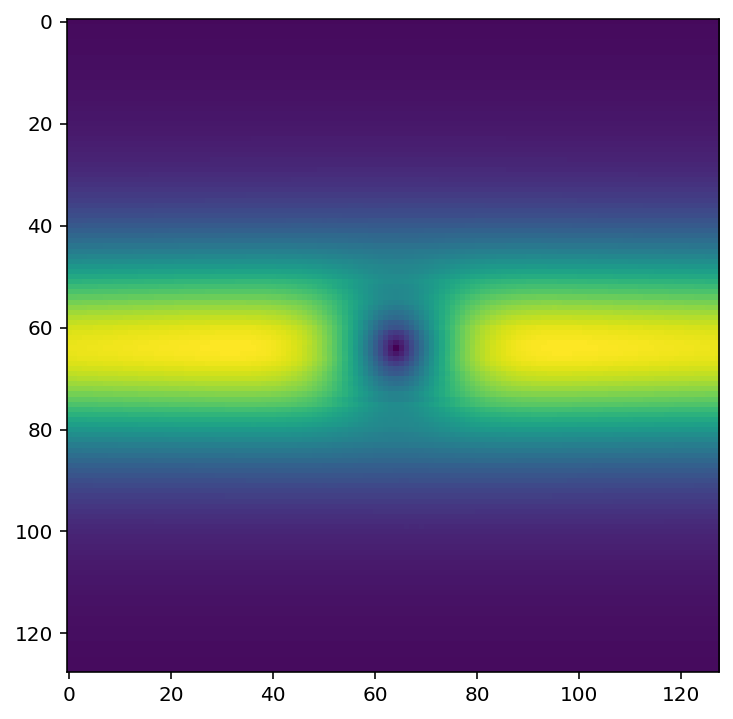

In [12]:
plt.imshow(np.hypot(R[:,BINS[1]//2,:], Rx[:,BINS[1]//2,:]))

In [13]:
# Factor to convert to MV/m
fpei=299792458**2 * 1e-7  # this is 1/(4 pi eps0)
factor = fpei / 1e6
factor

8987.551787368175

In [14]:
zlist = np.linspace(-6*SIGZ, 6*SIGZ, 1000)

zpts = np.array([[0,0,z] for z in zlist])
zpts.shape

(1000, 3)

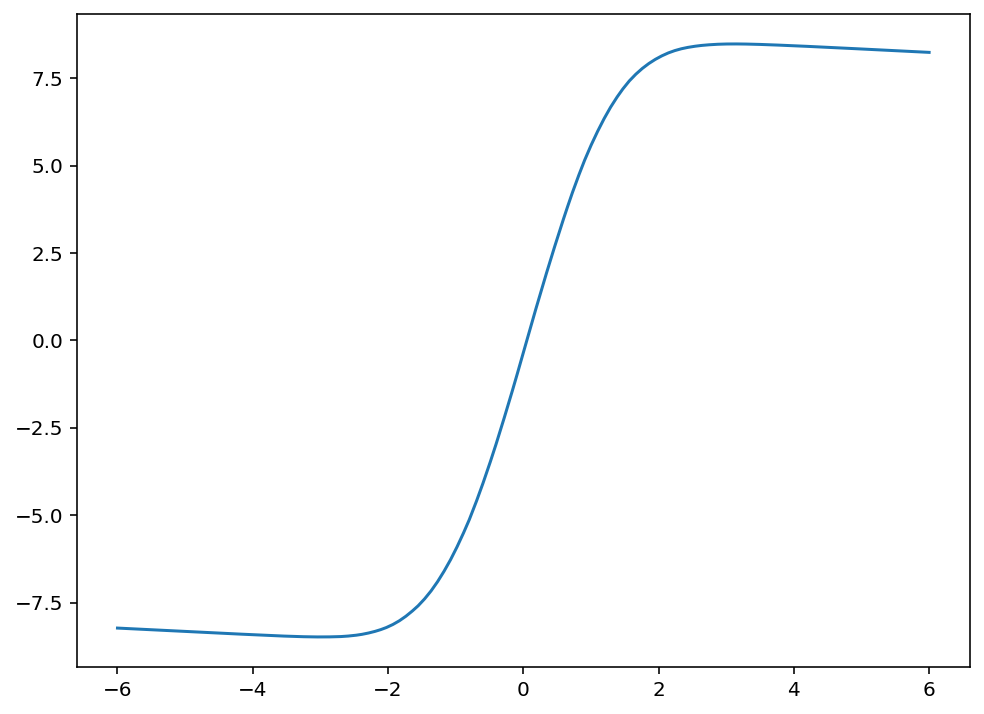

In [15]:
plt.plot(zlist/SIGZ, factor*interpn(coordvecs, R, zpts))

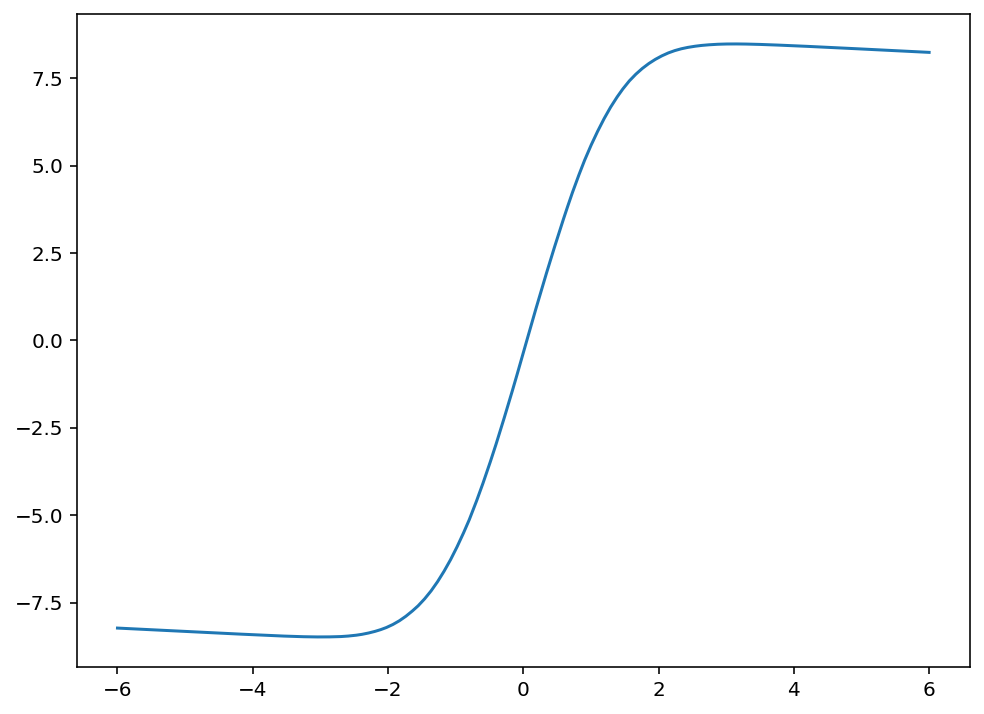

In [16]:
# Save Ez
Ez = factor*interpn(coordvecs, R, zpts)
zz = zlist/SIGZ

SAVE_EZ[RATIO] = Ez.copy()
SAVE_Z[RATIO] = zz.copy()
plt.plot(zz, Ez)

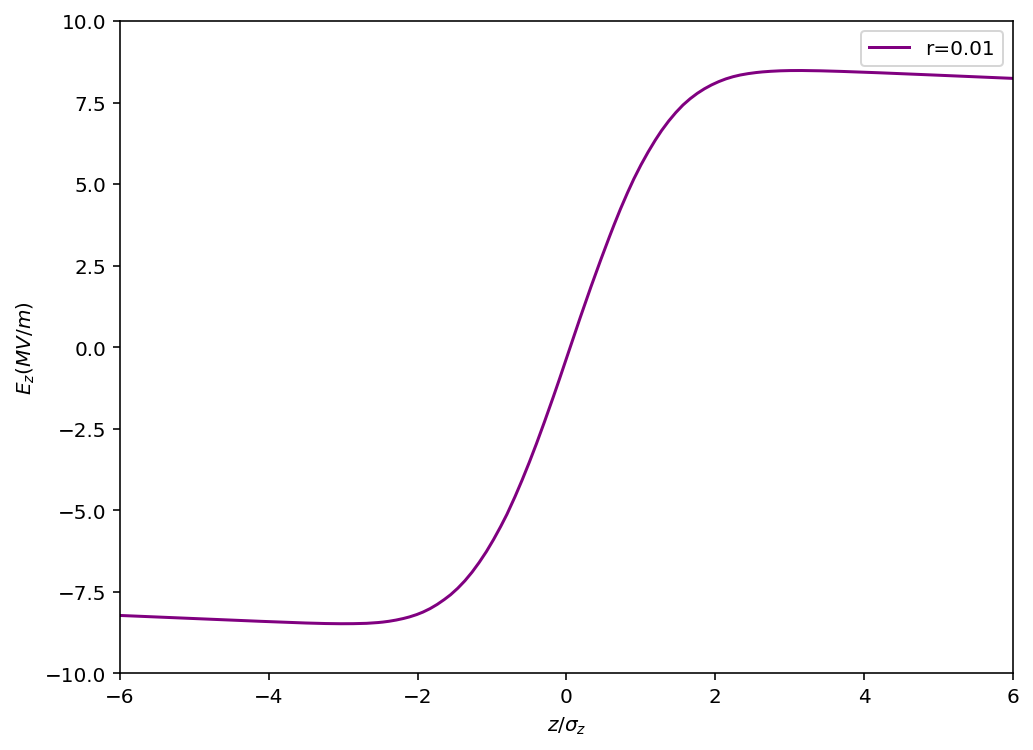

In [17]:
COLOR = {1:'black', 0.1:'blue', 0.01: 'purple', 10:'red'}

plt.xlim(-6, 6)
plt.ylim(-10,10)
plt.xlabel('$z/\sigma_z$')
plt.ylabel('$E_z (MV/m)$')
for r in SAVE_Z:
    plt.plot(SAVE_Z[r], SAVE_EZ[r], label=f'r={r}', color=COLOR[r])
plt.legend()